# Ещё раз про проверку статистических гипотез, альфу, бету, p-value...

* Ошибка I рода ($\alpha$) — на самом деле эффекта нет, но мы считаем, что он есть. 

* Ошибка II рода ($\beta$) — на самом деле эффект есть, но мы считаем, что его нет. 

Мы знаем, что наши тесты ошибаются. Нам надо иметь возможность контролировать вероятность ошибки.  
Так, мы чаще контролируем альфу, потому что она на практике более критична:  
1. Выбираем метрику;  
2. Устанавливаем порог ошибки первого рода;  
3. Если наше p-value меньше порога, то мы отвергаем нулевую гипотезу о том, что разницы нет, и говорим, что разница есть.

Мы уже познакомились с permutation test, но это не самый цимес. Актуальнее всего использовать **bootstrap**.

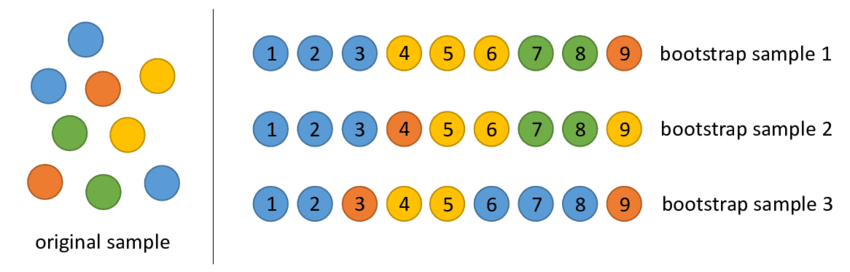

Суть состоит в том, мы пре делаем вид, что наша выборочная совокупность -- генеральная. А, вернее, что в ней сохранены те же правила, что и в генеральной: соотношение объектов, какие-то их свойства и тд.  

А дальше делаем из неё делаем много выборок, считаем для них статистику, строим распределение, оцениваем p-value.

Последовательность действий в нашем случае:   

    1. Нулевая гипотеза, что две выборки пришли из одной ген. совокупности. Так что мы их соединяем в случае permutation test.  
    2. Получаем много бутстрепных выборок, для каждой из них считаем статистику.    
    3. Оцениваем p-value.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, permutation_test, bootstrap
%matplotlib inline

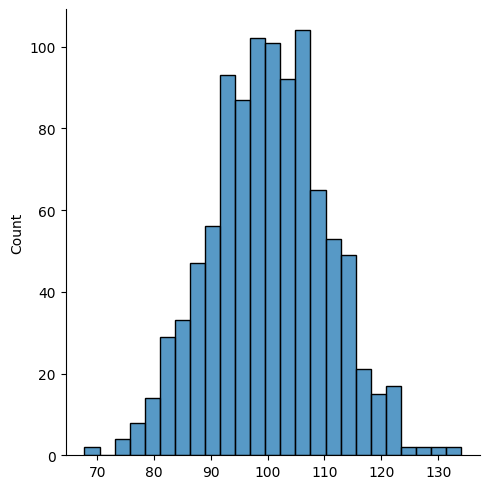

In [2]:
x = np.random.normal(loc=100, scale=10, size=1000) 
sns.displot(x)

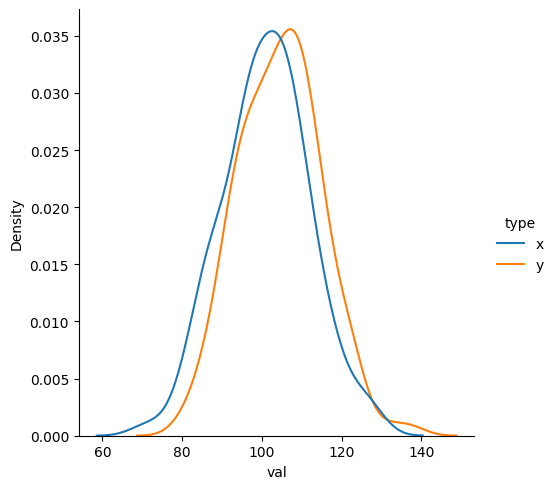

In [3]:
np.random.seed(21)

x = np.random.normal(loc=100, scale=10, size=100) 
y = np.random.normal(loc=105, scale=10.5, size=150)
df = pd.DataFrame({'val': np.concatenate([x, y]),
             'type': ['x'] * x.size + ['y'] * y.size})
sns.displot(data=df, x='val', hue='type', kind='kde', common_norm=False)

In [4]:
print(x.mean())
print(y.mean())

101.04420460658757
104.59656515858461


А теперь проведем синтетический тест.  
Мы знаем, что выборки пришли из разных распределений (у них разные параметры: среднее и станд.отклонение).  

In [5]:
# t-test
ttest_ind(y, x)

Ttest_indResult(statistic=2.62991032981259, pvalue=0.00907487669260211)

Разница по факту: 3.55236055
P-value (test) 0.004995
P-value (просто процент) 0.004


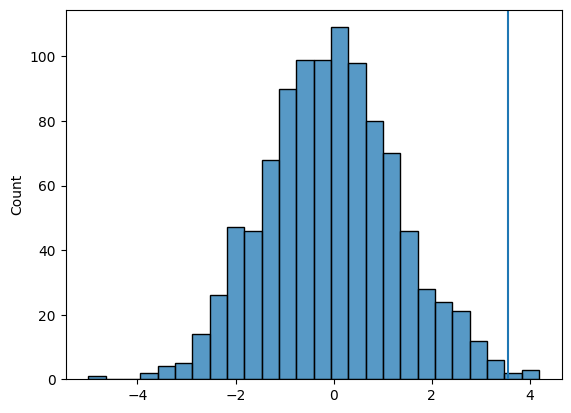

In [6]:
# permutation test
def mean_diff(a, b):
    return b.mean() - a.mean()

diffs = permutation_test([x, y], mean_diff, n_resamples=1000, alternative='greater')
print("Разница по факту:", round(diffs.statistic, 8))
print("P-value (test)", round(diffs.pvalue, 8))
print("P-value (просто процент)", (diffs.statistic < diffs.null_distribution).mean())

sns.histplot(diffs.null_distribution)
plt.axvline(diffs.statistic)

In [24]:
# bootstrap
# хорошая КОРОТКАЯ, ПОНЯТНАЯ статья про бутстрам 
# https://habr.com/ru/company/X5Tech/blog/679842/
# 

real_difference = y.mean() - x.mean()
bootstrap_x = np.random.choice(x, (1000, x.size))
bootstrap_y = np.random.choice(y, (1000, y.size))

In [25]:
bootstrap_y.shape

(1000, 150)

In [26]:
bootstrap_x.shape # как выглядит матрица

(1000, 100)

In [27]:
bootstrap_x.mean(axis=1).shape # среднее для каждой бутстрапной выборки

(1000,)

In [28]:
diffs =  bootstrap_y.mean(axis=1) - bootstrap_x.mean(axis=1)
diffs.shape

(1000,)

In [29]:
def get_percentile_ci(bootstrap_stats, alpha):
    """
    Строит перцентильный доверительный интервал.
    На практике его не особо используют, но зато он самый понятный.
    """
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [30]:
# то есть этот интервал с вероятностью 95% покрывает разницу в средних
ci = get_percentile_ci(diffs, 0.05) 
ci

(0.6596771125422454, 6.171785675444457)

In [34]:
ci[0] < real_difference < ci[1]
# попали ли мы на него? 
# нет
# значит эффект есть!

True

In [35]:
real_difference

3.5523605519970403

Pval 0.504


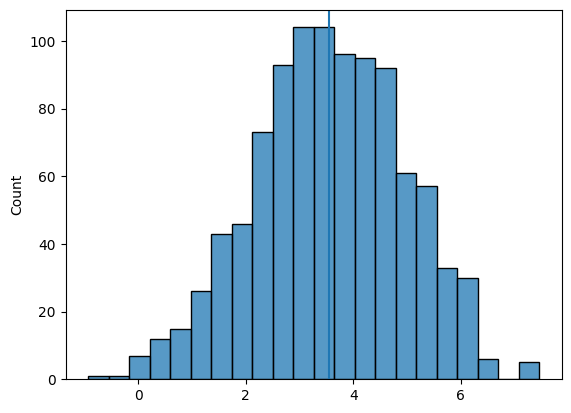

In [36]:
sns.histplot(diffs)
plt.axvline(real_difference)
print("Pval", (diffs > real_difference).mean()) # наша оценка p-value

In [17]:
# теперь оценим альфу и мощность тестов (1 - beta)

# Минимальный регистрируемый эффект
# Размер выборки

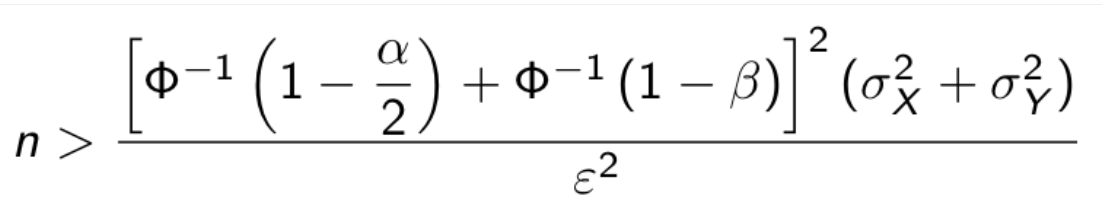

где $\alpha$ -- вероятность ошибки I рода, $\beta$- вероятность ошибки II рода, $\sigma^2$ - дисперсии значений в контрольной и экспериментальной группах, $\epsilon$ - минимальный ожидаемый эффект, а Ф$^{-1}$ -- квантильная функция.

In [38]:
import numpy as np    
from scipy import stats

alpha = 0.05                    # вероятность ошибки I рода
beta = 0.2                      # вероятность ошибки II рода
mu_control = 2000               # средняя выручка с пользователя в контрольной группе
effect = 100                    # размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 500                       # стандартное отклонение

t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
var = 2 * std ** 2
sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
print(f'sample_size = {sample_size}')

sample_size = 392


In [39]:
first_type_errors = []
second_type_errors = []
 
sample_size = 400
 
for _ in range(10000):
    control_one = np.random.normal(mu_control, std, sample_size)
    control_two = np.random.normal(mu_control, std, sample_size)
    pilot = np.random.normal(mu_pilot, std, sample_size)
    _, pvalue_aa = stats.ttest_ind(control_one, control_two)
    first_type_errors.append(pvalue_aa < alpha)
    _, pvalue_ab = stats.ttest_ind(control_one, pilot)
    second_type_errors.append(pvalue_ab >= alpha)

part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

part_first_type_errors = 0.050
part_second_type_errors = 0.203


Или с помощью онлайн-калькуляторов: https://www.evanmiller.org/ab-testing/sample-size.html

<AxesSubplot: ylabel='Density'>

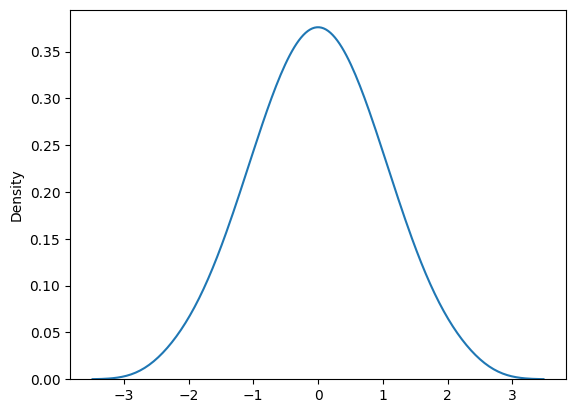

In [20]:
# ПОЧЕМУ ВЕЗДЕ ЭТО ppf??? ЧТО ЭТО??? ОТКУДА????
sns.kdeplot([stats.norm.ppf(i/100) for i in range(1, 100)])

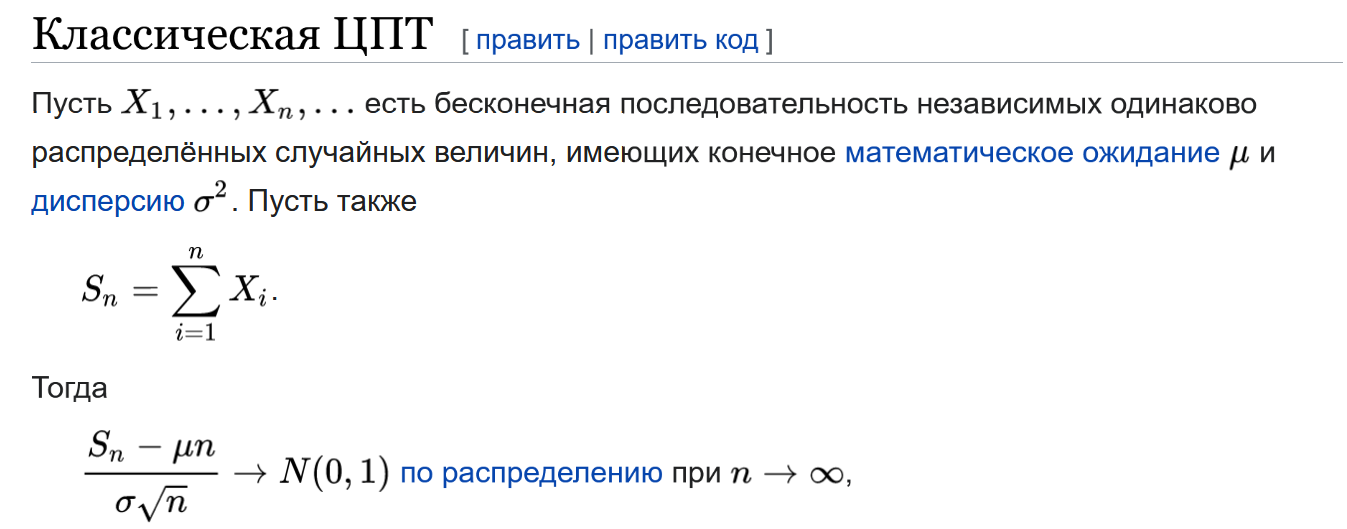

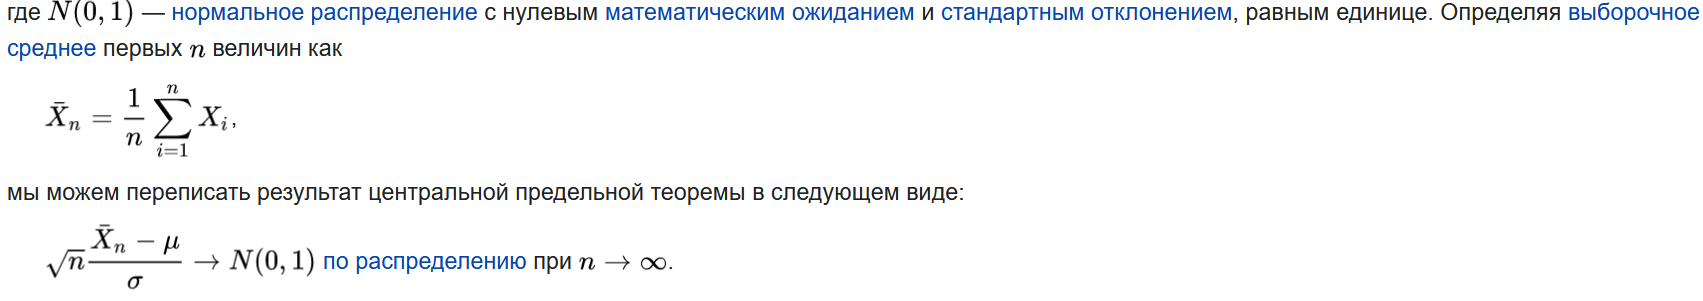

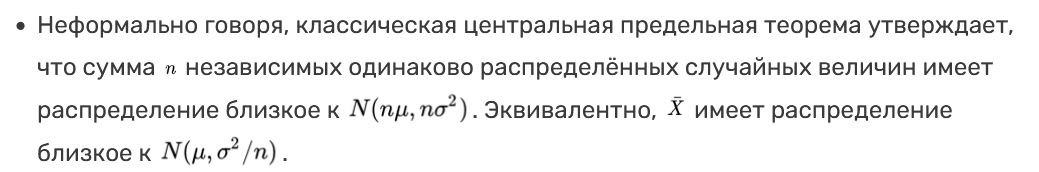

Понятнее здесь: https://www.codecamp.ru/blog/central-limit-theorem/

In [21]:
from scipy.stats import expon, bootstrap

0.9591378195551804
0.938292053571226


<AxesSubplot: ylabel='Density'>

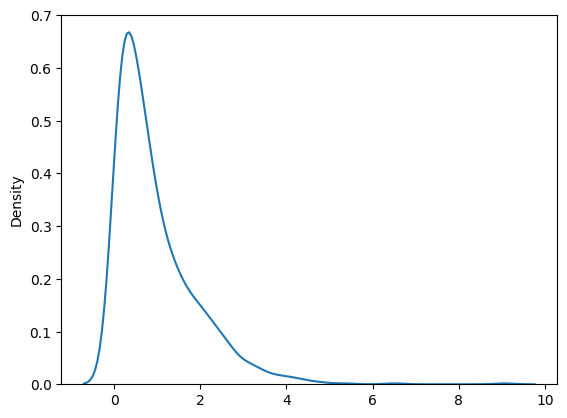

In [22]:
r = expon.rvs(size=1000)
print(r.mean())
print(r.std())
sns.kdeplot(r)

In [23]:
np.random.seed(10)

means = []

for n in 10, 100, 10000:
    means.append(np.array([np.random.choice(r, size=100, replace=False).mean() for _ in range(n)]))

In [24]:
df = pd.DataFrame({'val':np.concatenate(means), 
              'n=': np.repeat(['10', '100','10000'], [10, 100, 10000])})
df

,val,n=
0,0.856064,10
1,1.091485,10
2,0.940376,10
3,0.912050,10
4,0.978535,10
...,...,...
10105,0.919439,10000
10106,1.131221,10000
10107,1.127520,10000
10108,1.002878,10000


<AxesSubplot: xlabel='val', ylabel='Density'>

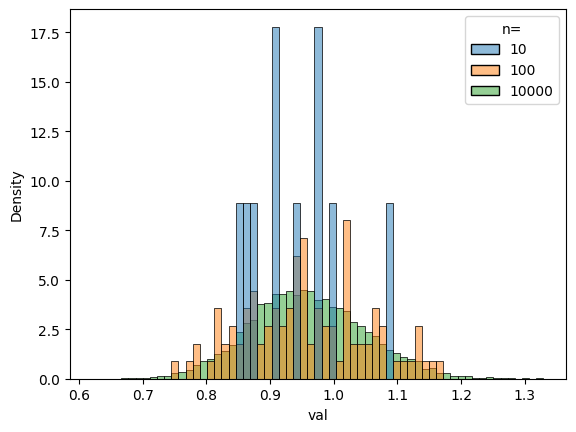

In [25]:
sns.histplot(data=df, x='val', hue='n=', common_norm=False, stat='density') 
# не похоже на стандартное нормальное # что забыли?

In [26]:
df['norm'] = df.groupby('n=')['val'].transform(lambda x: 
                                (x - r.mean()) / r.std() * 100 ** 0.5)

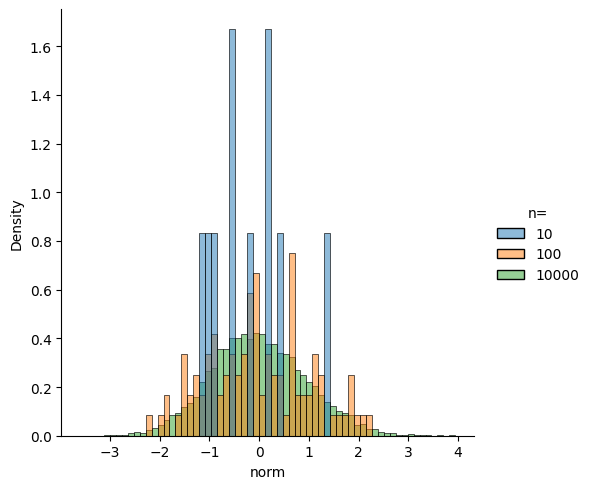

In [27]:
sns.displot(data=df, x='norm', hue='n=', common_norm=False, kind='hist', stat='density') 
# не похоже на стандартное нормальное # что забыли?

In [28]:
np.random.seed(10)
print(np.random.random())

0.771320643266746


In [29]:
def get_random_number():
    num = np.random.random() * 10 ** np.random.randint(3, 6)
    if str(num).count('0') > 2:
        num /= 3
    elif str(num).count('11') > 0:
        num *= np.pi
    elif num > 1_000_000:
        num = np.log(num)
    elif num < 1000:
        num = (num + 100) * 1000
    return num
        
x = np.array([get_random_number() for _ in range(100)])

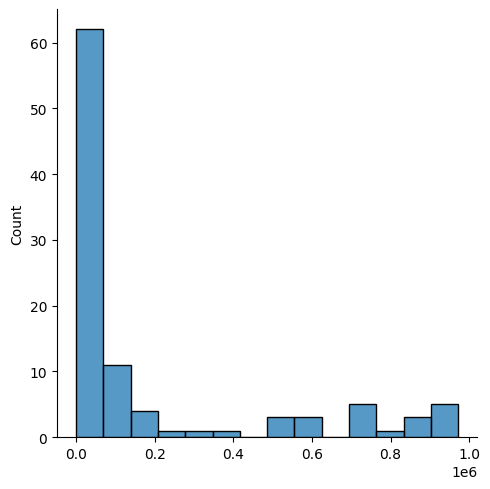

In [30]:
sns.displot(x)

In [36]:
means = np.array([np.random.choice(x, size=30, replace=False).mean() for _ in range(3000)])

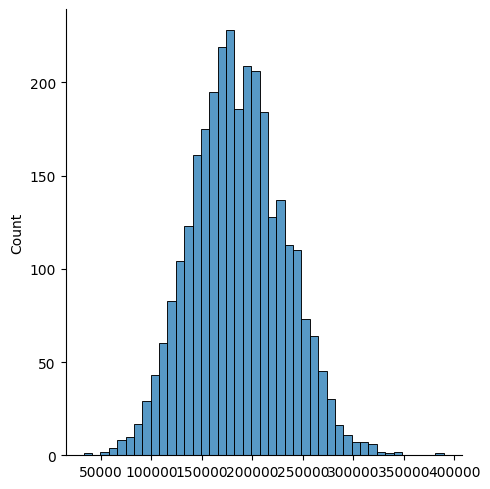

In [37]:
sns.displot(means)

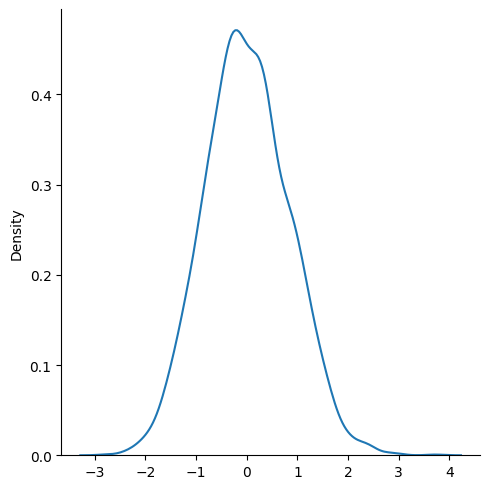

In [38]:
sns.displot((means - x.mean()) / x.std() * np.sqrt(30),  kind='kde')

In [39]:
import scipy.stats as st

In [40]:
st.shapiro(means)

ShapiroResult(statistic=0.998175323009491, pvalue=0.001635815599001944)